In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("~/Downloads/Amazon_Unlocked_Mobile.csv")

In [3]:
#Find missing value and remove na to the original data
df.dropna(inplace=True)

In [4]:
#Create new column name "High Rate" with value 1 stands for rating higher or equal to 4 and 0 is not
df['High_Rate'] = np.where(df['Rating']>=4,1,0)

In [6]:
#Split data into training and testing using 60% data for training
# only 1 input variable which is Review and predictand is the High Rate column
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df['Reviews'],df['High_Rate'],train_size=0.6,
                                                random_state=123)

In [7]:
# Now for sentiment analysis, one need to vectorize the Review in to different tokens/words
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
#Fit CountVectorizer to training data
vect = CountVectorizer().fit(X_train)

In [10]:
#Transform train and test predictor to vectorized tokens:
X_train_vectorize = vect.transform(X_train)
X_test_vectorize = vect.transform(X_test)

In [25]:
# Now lets's train the Machine Learning model using Logistic Regression
from sklearn.linear_model import LogisticRegression

#Create Logistic Regression model, here I use newton-cg as solver as it converges quite well with the data
#Also note that Logistic Regression running in parallel using all possible cores running in SMU ManeFrame
model_LogReg = LogisticRegression(solver='newton-cg').fit(X_train_vectorize,y_train)


In [27]:
#Predict for the testing data using model_LogReg
y_pred_LogReg = model_LogReg.predict(X_test_vectorize)

In [28]:
#Evaluate model output:
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred_LogReg)

0.9216579179565406

In [29]:
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt
# predict probabilities
lr_probs_LogReg = model_LogReg.predict_proba(X_test_vectorize)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.960


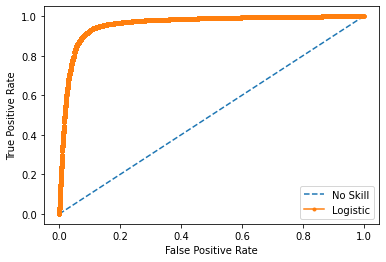

In [32]:
# generate a no skill prediction (majority class)
ns_probs = np.zeros(len(y_test))

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs_LogReg[:,1])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_LogReg[:,1])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

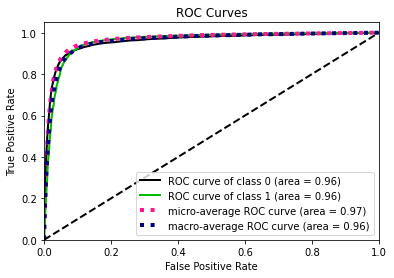

In [34]:
import scikitplot as skplt
skplt.metrics.plot_roc(y_test,lr_probs_LogReg)
plt.show()

In [35]:
#Alternatively, I would like to try using Ensemble approach with Random Forest, using 20 different trees
#Unfortunately, the Random Forest only use single core SMU ManeFrame, so the processing is much slower compared to Logistic Regression
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(n_estimators=20,criterion="gini").fit(X_train_vectorize,y_train)

In [37]:
y_pred_RF = model_RF.predict(X_test_vectorize)

In [38]:
metrics.accuracy_score(y_pred_RF,y_test)


0.9439559124829886

In [39]:
metrics.accuracy_score(y_pred_LogReg,y_test)

0.9216579179565406

In [41]:
#Using Gradient Boosting Machine
from sklearn.ensemble import GradientBoostingClassifier
model_GBM = GradientBoostingClassifier(n_estimators=100).fit(X_train_vectorize,y_train)


In [42]:
model_GBM.score(X_test_vectorize,y_test)

0.8337969401947148

Remarks:

- Sentiment Analysis using Reviews from Amazon Unlocked Mobile device. 

- Three different methods are applied: (1) Logistic Regression (2) Random Forest and (3) Gradient Boosting Machine
    

- Logistic Regression is able to utilize all cores in the compute node and is faster
- RandomForest and GBM are using only single core in compute node and are slower
- For testing dataset, GBM has lowest accuracy at 83% whilst Random Forest has highest one at 94.3%
- Logistic Regression is preferable in this case study with accuracy of 92% but with faster processing speed